In [641]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize'] = [7.2, 4.8]
pd.set_option("display.float_format", lambda x: "%.4f" % x)

sns.set_style('darkgrid')

SEED = 123

In [642]:
import numpy as np
import pandas as pd
df = pd.read_csv("/content/churn.txt")

# denoting churn and duration
df["event"] = np.where(df["Churn?"] == "False.", 0, 1)
df = df.rename(columns={"Account Length": "duration"})

del df['Churn?']

df = df.dropna()
df = df.drop_duplicates()
df.head()

,State,duration,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,event
0,PA,163,806,403-2562,no,yes,300,8.1622,3,7.5792,...,4,6.5086,4.0658,100,5.1116,4.9282,6,5.6732,3,1
1,SC,15,836,158-8416,yes,no,0,10.0190,4,4.2263,...,0,9.9726,7.1410,200,6.4362,3.2217,6,2.5597,8,0
2,MO,131,777,896-6253,no,yes,300,4.7085,3,4.7682,...,3,4.5667,5.3632,100,5.1425,7.1390,2,6.2542,4,0
3,WY,75,878,817-5729,yes,yes,700,1.2687,3,2.5676,...,5,2.3336,3.7736,450,3.8144,2.2458,6,1.0807,6,0
4,WY,146,878,450-4942,yes,no,0,2.6962,3,5.9089,...,3,3.6704,3.7517,250,2.7968,6.9055,4,7.1343,6,1


In [643]:
print("Total Records:",df.shape[0],"\n")
print("Percent Churn Rate:",df.event.mean())
print("")
print("Duration Intervals")
print(df['duration'].describe())

Total Records: 5000 

Percent Churn Rate: 0.4996

Duration Intervals
count   5000.0000
mean     101.6758
std       57.5968
min        1.0000
25%       52.0000
50%      102.0000
75%      151.0000
max      200.0000
Name: duration, dtype: float64


In [644]:
df.columns

Index(['State', 'duration', 'Area Code', 'Phone', 'Int'l Plan', 'VMail Plan',
       'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins',
       'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge',
       'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'event'],
      dtype='object')

In [645]:
!pip install lifelines

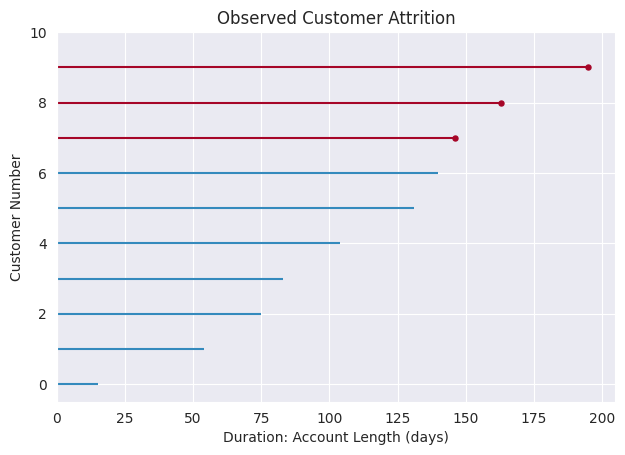

In [646]:
from lifelines.plotting import plot_lifetimes
import matplotlib.pyplot as plt

ax=plot_lifetimes(df.head(10)['duration'], df.head(10)['event'])
_=ax.set_xlabel("Duration: Account Length (days)")
_=ax.set_ylabel("Customer Number")
_=ax.set_title("Observed Customer Attrition")

🔴**Red lines with dot**- indicates when customer left with the exact duration as the dot

🔵**Blue line**- customers still active up until the measured duration

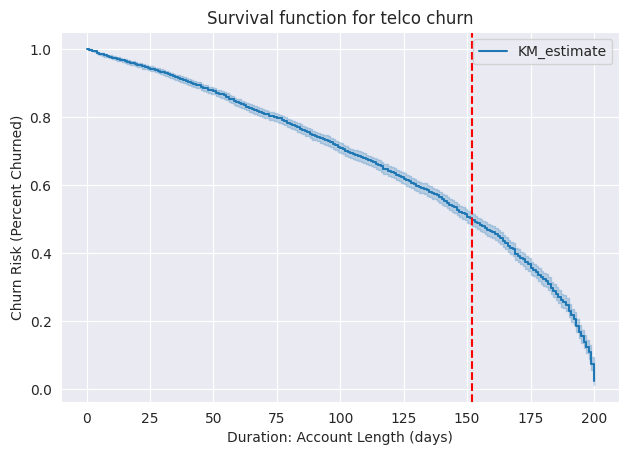

In [647]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf= KaplanMeierFitter()

kmf.fit(df['duration'],event_observed=df['event'])

kmf.plot_survival_function()
_=plt.title('Survival function for telco churn');
_=plt.xlabel("Duration: Account Length (days)")
_=plt.ylabel("Churn Risk (Percent Churned)")
_=plt.axvline(x=kmf.median_survival_time_, color='r',linestyle='--')

🔴red-line: where probability drops to 50%
This is the point by which half of customers have churned out

In [648]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# df = add_features(df)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

numerical_idx = (df.select_dtypes(exclude=['object','category'])
                   .drop(['event','duration'], axis=1)
                   .columns.tolist())

categorical_idx = (df.select_dtypes(include=['object','category'])
                     .columns.tolist())

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numeric_transformer, numerical_idx),
        ("categorical", categorical_transformer, categorical_idx)
    ],
    remainder="passthrough"
)

train_features = preprocessor.fit_transform(df_train.drop(['event','duration'], axis=1))
test_features = preprocessor.transform(df_test.drop(['event','duration'], axis=1))


In [649]:
import xgboost as xgb

def survival_y_cox(dframe:pd.DataFrame) -> np.array:
    """Returns array of outcome encoded for XGB"""
    y_survival = []

    for idx, row in dframe[["duration", "event"]].iterrows():
        if row["event"]:
            # uncensored
            y_survival.append(int(row["duration"]))
        else:
            # right censored
            y_survival.append(-int(row["duration"]))
    return np.array(y_survival)


# feature_names = preprocessor.get_feature_names_out().tolist()

# dm_train = xgb.DMatrix(
#     train_features, label=survival_y_cox(df_train), feature_names=feature_names
# )

# dm_test = xgb.DMatrix(
#     test_features, label=survival_y_cox(df_test), feature_names=feature_names
# )


In [650]:
feature_names = np.hstack((
    np.array(numerical_idx),
    preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_idx)
)).tolist()


dm_train = xgb.DMatrix(
    train_features, label=survival_y_cox(df_train), feature_names=feature_names
)

dm_test = xgb.DMatrix(
    test_features, label=survival_y_cox(df_test), feature_names=feature_names
)

In [651]:
params = {
    "eta": 0.1,
    "max_depth": 3,
    "objective": "survival:cox",
    "tree_method": "hist",
    "subsample": 0.8,
    "seed": 123
}
bst = xgb.train(
    params,
    dm_train,
    num_boost_round=1000,
    evals=[(dm_train, "train"), (dm_test, "test")],
    verbose_eval=int(1e1),
    early_stopping_rounds=2
)

# df_test = df_test.copy()   # avoid pandas SettingWithCopyWarning
# df_test["preds"] = preds


[0]	train-cox-nloglik:7.24545	test-cox-nloglik:5.90088
[10]	train-cox-nloglik:6.98698	test-cox-nloglik:5.66293
[20]	train-cox-nloglik:6.89271	test-cox-nloglik:5.57598
[30]	train-cox-nloglik:6.84910	test-cox-nloglik:5.54554
[37]	train-cox-nloglik:6.82627	test-cox-nloglik:5.53784


In [652]:
df_test.loc[:,"preds"] = bst.predict(dm_test, output_margin=True)
df_test.loc[:, "preds_exp"] = bst.predict(dm_test, output_margin=False)

/tmp/ipython-input-3749415787.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _=df_test.groupby(pd.qcut(df_test['duration'], q=20))['preds_exp'].median().plot(kind="bar")


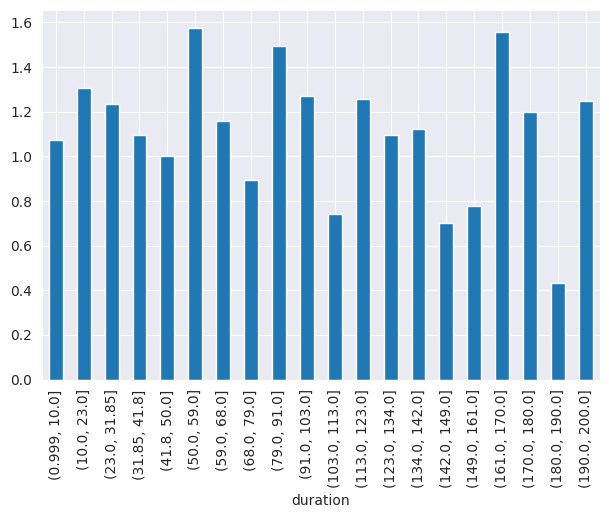

In [653]:
_=df_test.groupby(pd.qcut(df_test['duration'], q=20))['preds_exp'].median().plot(kind="bar")


In [654]:
pip install scikit-survival

In [655]:
from sksurv.metrics import concordance_index_ipcw, brier_score
from sksurv.util import Surv

y_train = Surv.from_dataframe("event", "duration", df_train)
y_test = Surv.from_dataframe("event", "duration", df_test)

print("CIC")
print(
    concordance_index_ipcw(
        y_train,
        y_test,
        df_test['preds'],
        tau=100
    )
)


print("Brier Score")
times,score=brier_score(
    y_train,
    y_test,
    df_test['preds'],
    df_test['duration'].max()-1
)
print(score)

CIC
(np.float64(0.7262045046456096), np.int64(179840), np.int64(69301), np.int64(45), np.int64(1223))
Brier Score
[0.47642534]


In [656]:
!pip install shap

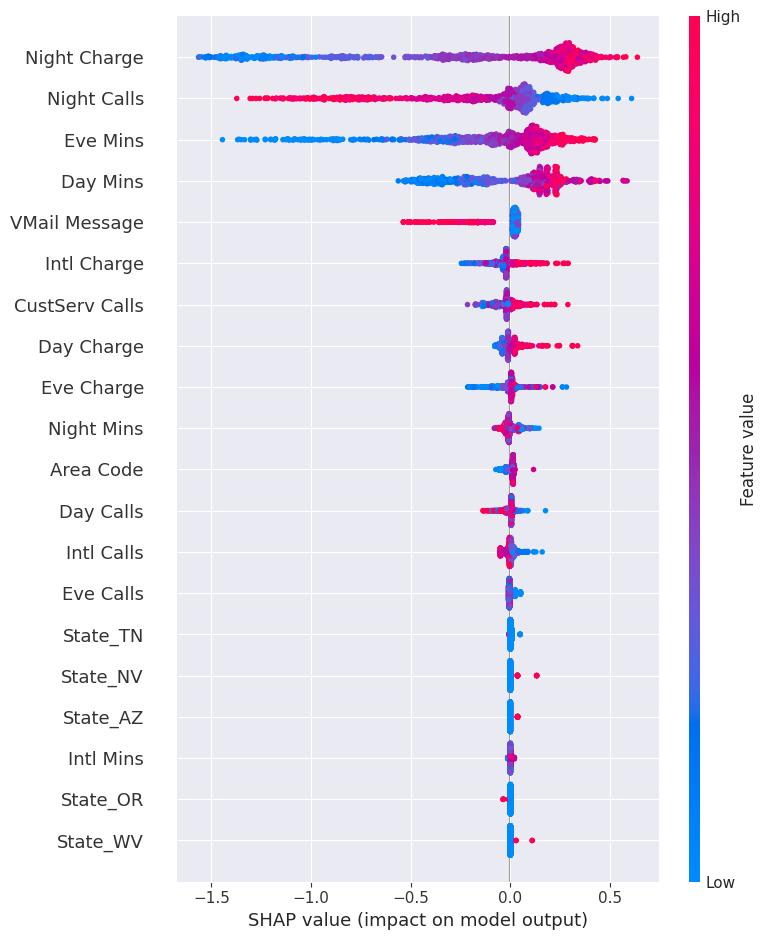

In [657]:
import shap

explainer = shap.TreeExplainer(bst, feature_names=feature_names)
shap_values = explainer.shap_values(test_features)

shap.summary_plot(shap_values, pd.DataFrame(test_features, columns=feature_names))

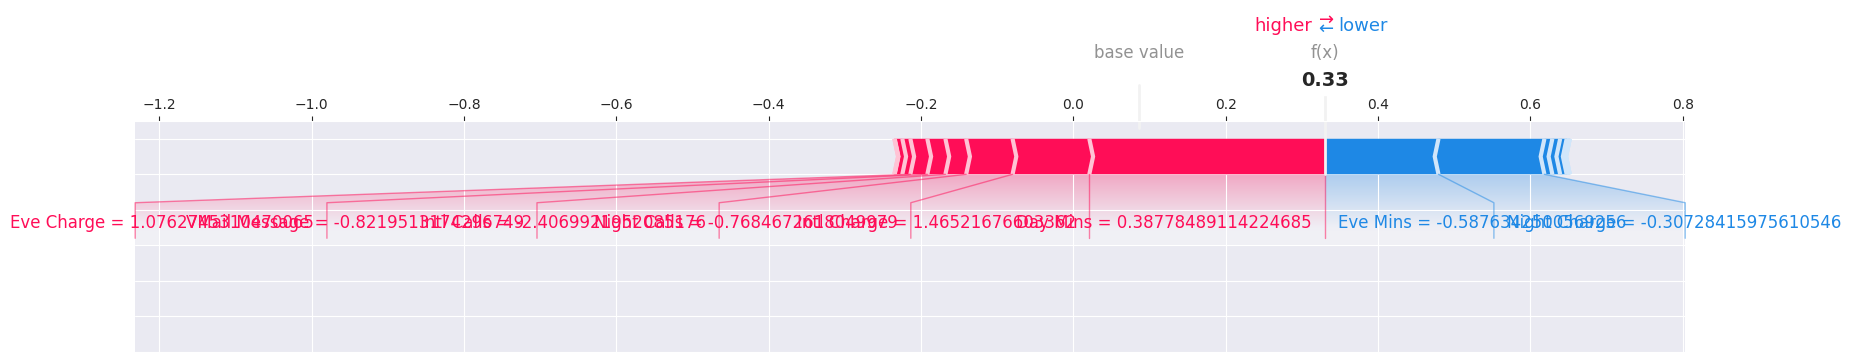

The real label is Churn=True


In [658]:
idx_sample = 128
shap.force_plot(
    explainer.expected_value,
    shap_values[idx_sample, :],
    pd.DataFrame(test_features, columns=feature_names).iloc[idx_sample, :],
    matplotlib=True,
)

print(f"The real label is Churn={y_test[idx_sample][0]}")

In [659]:
xgb.plot_tree(bst, rankdir="LR", num_trees=0)
fig = plt.gcf()
fig.set_size_inches(150, 100)

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


In [660]:
from sklearn import metrics

y_preds = df_test.preds.apply(lambda x : np.exp(x))
y_pred = np.where(y_preds > 0.5, 1, 0)

print(f"Accuracy score: {metrics.accuracy_score(df_test.event, y_pred)}")
print(f"Area Under the Curve {metrics.roc_auc_score(df_test.event, y_pred)}")
print("")
print(metrics.classification_report(df_test.event, y_pred))

Accuracy score: 0.838
Area Under the Curve 0.8406162464985993

              precision    recall  f1-score   support

           0       0.96      0.71      0.82       510
           1       0.76      0.97      0.85       490

    accuracy                           0.84      1000
   macro avg       0.86      0.84      0.84      1000
weighted avg       0.86      0.84      0.84      1000



# Example

In [670]:
scores = np.random.normal(size=20).reshape(2,10)
scores_df = pd.DataFrame(scores
                         , index=['Customer A', 'Customer B']
                         , columns=[10,20,30,40,50,60,70,80,90,100])
scores_df


,10,20,30,40,50,60,70,80,90,100
Customer A,0.0869,0.1081,-0.2162,-0.0278,1.8466,-1.3179,0.2717,1.4629,0.8590,-1.4565
Customer B,-1.5093,1.8116,-1.0615,0.2370,-0.9014,-0.7442,1.4394,-0.5122,0.2923,-0.0219


# Know when to intervene

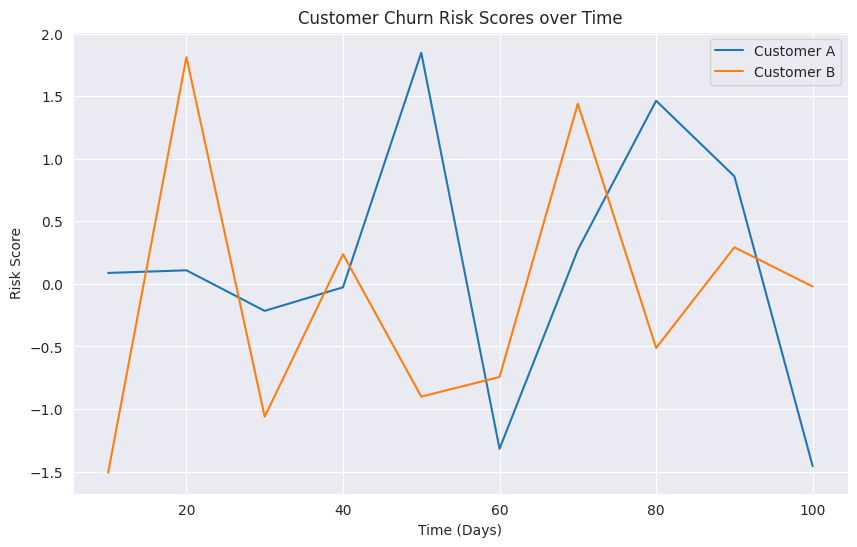

In [672]:
plt.figure(figsize=(10, 6))

for customer in scores_df.index:
    plt.plot(scores_df.columns, scores_df.loc[customer], label=customer)

plt.title('Customer Churn Risk Scores over Time')
plt.xlabel('Time (Days)')
plt.ylabel('Risk Score')
plt.legend()
plt.grid(True)
plt.show()